# <span style="color:orange">Image segmentation - Exercise </span>

<a href="https://colab.research.google.com/github/datarootsio/workshop-image-segmentation-style-transfer/blob/main/notebooks/exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to this exercise session about image segmentation and style transfer. If you haven't followed the tutorial yet, we recommend that you do the tutorial first before completing this excercise. This is an exercise to get familiar with tool for image segmentation and style transfer. 

<span style="color:red">IMPORTANT INSTRUCTIONS: </span>
Please make a copy of this notebook, upload it into your own google drive.

If you decided to open this notebook without cloning the entire GitHub repository, please make sure to upload all the needed files manually. 

![Maintainer](https://dataroots.io/maintained-rnd.svg)

# 1 Objectives

The final objective of this exercise is to customize a wall frame that is hanging on the wall in Dataroots' office. To do this, you will have to apply a style of your choice to make the frame more beautiful. However, we do not give you an image containing only the content of the frame to be personalized. Indeed, your original image is a picture of the Dataroots' office. It is up to you to create a model to detect the frame and apply your best style to this object!


In other words, the goal of this exercise session is to learn how to train a new image segmentation model capable of detecting frames on a picture instead of sofas. You might think that all you have to do is change the class of the object to be detected from "sofa" to "frame". Unfortunately, it's not as simple as that. 

## Install useful packages

Before installing useful packages, make sure you are using GPU runtime. To be sure that the GPU device is detected, run the following cell. 

If the current runtime type that you're using is not GPU, please go to Runtime --> Change runtime type --> Choose"GPU" as hardware accelerator

In [62]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


We need to install a specific version for each python packages that will be used in this exercise session. We first pipe all these useful packages into a requirements.txt file before installing them. This step can take several minutes to run.

In [6]:
!printf 'opencv-python \ncython \nscikit-image \nh5py \nimgaug \nIPython \ntorch==1.8.0 \ntorchvision==0.9.0 \ncolormap \nipympl \neasydev \nopencv-contrib-python \npillow \nnumpy \nscipy==1.4.1 \ntqdm \nmatplotlib==3.1.1 \nipykernel \ntensorflow==2.2 \nkeras==2.3.1' > requirements.txt

In [7]:
!pip install -q --disable-pip-version-check --no-color -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 68.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 KB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.8/377.8 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 84.3 MB/s eta 

After the installation of all useful packages that will be used in this exercise session, please restart the runtime to be sure that everything is installed properly.

## Connection to GCP bucket

For ease of access, we have stored the data in the cloud (GCP). 
Before being able to access data from a GCP bucket, you first need to login into GCP using the following command. Please follow the instructions!

In [8]:
from google.colab import auth
auth.authenticate_user()

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

!mkdir /content/data_bucket
!gcsfuse --implicit-dirs home_design_bucket /content/data_bucket

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1210  100  1210    0     0  16805      0 --:--:-- --:--:-- --:--:-- 16805
OK
22 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 22 not upgraded.
Need to get 13.8 MB of archives.
After this operation, 32.2 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 128215 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.42.1_amd64.deb ...
Unpacking gcsfuse (0.42.1) ...
Setting up gcsfuse (0.42.1) ...
2023/03/04 12:51:15.868886 Start gcsfuse/0.42.1 (Go version go1.19.5) for app "" using mount point: /content/data_bucket
2023/03/04 12:51:15.888370 Opening GCS connection...
2023/03/04 12:51:16.758244 Mounting file system "home_de

Now that you are connected to GCP with your personnal account, you can access the bucket containing the data.

In [9]:
import os
DATA_DIR = '/content/data_bucket'

x_train_dir = os.path.join(DATA_DIR, 'train_frames/images')
y_train_dir = os.path.join(DATA_DIR, 'train_frames/masks')

x_valid_dir = os.path.join(DATA_DIR, 'validation_frames/images')
y_valid_dir = os.path.join(DATA_DIR, 'validation_frames/masks')

In [10]:
!git clone https://github.com/datarootsio/workshop-image-segmentation-style-transfer.git

Cloning into 'workshop-image-segmentation-style-transfer'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 109 (delta 2), reused 8 (delta 2), pack-reused 101
Receiving objects: 100% (109/109), 37.66 MiB | 21.83 MiB/s, done.
Resolving deltas: 100% (47/47), done.


# 2 How to create the new dataset set?

In the tutorial, we used a dataset that had already been sorted. Indeed, all the images contained a sofa since the objective was to detect this object. In this exercise session, the new objective is to detect frames rather than sofas on the same dataset. 

The dataset used contains annotations, which allow us to categorize the objects easily. Let's look at what these annotations look like and whether we can use them to detect frames. 

## 2.1 Load annotations relative to training set

The annotations are contained in a file in json format. Let's load the annotation file relative to the training set and observe the categories of objects that can be detected using this dataset. Small reminder: the dataset contains images of indoor virtual spaces.

In [11]:
import os
import json
from pycocotools.coco import COCO
import numpy as np

annotation_file = os.path.join(DATA_DIR, "raw_data/info/categories.json")

with open(annotation_file) as json_data:
        annotations = json.load(json_data)
        cats = annotations["categories"]
        super_categories = np.unique(np.array([cat["super-category"] for cat in cats]))
        print("Main categories of objects that can be detected: \n", super_categories)
        categories = np.unique(np.array([cat["category"] for cat in cats]))
        print("\n Categories of objects that can be detected: \n", categories)


Main categories of objects that can be detected: 
 ['Bed' 'Cabinet/Shelf/Desk' 'Chair' 'Lighting' 'Pier/Stool' 'Sofa' 'Table']

 Categories of objects that can be detected: 
 ['Barstool' 'Bed Frame' 'Bookcase / jewelry Armoire' 'Bunk Bed'
 'Ceiling Lamp' 'Chaise Longue Sofa' 'Children Cabinet'
 'Classic Chinese Chair' 'Coffee Table' 'Corner/Side Table' 'Desk'
 'Dining Chair' 'Dining Table' 'Drawer Chest / Corner cabinet'
 'Dressing Chair' 'Dressing Table'
 'Footstool / Sofastool / Bed End Stool / Stool' 'Kids Bed'
 'King-size Bed' 'L-shaped Sofa' 'Lazy Sofa'
 'Lounge Chair / Cafe Chair / Office Chair' 'Loveseat Sofa' 'Nightstand'
 'Pendant Lamp' 'Round End Table' 'Shelf'
 'Sideboard / Side Cabinet / Console table' 'Single bed' 'TV Stand'
 'Three-seat / Multi-seat Sofa' 'Wardrobe' 'Wine Cabinet' 'armchair']


We observe that there is no category for frames in the annotations of the dataset we used. We are therefore faced with a major problem: the frames category is not represented in the COCO dataset, so our dataset does not contain labeled examples for frames.

## 2.2 Let's try to detect frames using Mask RCNN

We saw in the previous section that the "frame" category is not represented in the COCO dataset. In order to verify this information and to visually observe that an object detection model pre-trained on the coco dataset is not able to detect frames, we will try to detect frames using [Mask RCNN](https://github.com/matterport/Mask_RCNN.git).

You first have to clone the repository containing the code to run.

In [12]:
!git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git

Cloning into 'Mask-RCNN-TF2'...
remote: Enumerating objects: 1440, done.
remote: Total 1440 (delta 0), reused 0 (delta 0), pack-reused 1440
Receiving objects: 100% (1440/1440), 157.00 MiB | 22.40 MiB/s, done.
Resolving deltas: 100% (794/794), done.


In [13]:
%cd Mask-RCNN-TF2

/content/Mask-RCNN-TF2


In [14]:
import urllib.request
import shutil

def download_trained_weights(coco_model_path, verbose=1):
    """Download COCO trained weights from Releases.

    coco_model_path: local path of COCO trained weights
    """
    COCO_MODEL_URL = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"
    if verbose > 0:
        print("Downloading pretrained model to " + coco_model_path + " ...")
    with urllib.request.urlopen(COCO_MODEL_URL) as resp, open(coco_model_path, 'wb') as out:
        shutil.copyfileobj(resp, out)
    if verbose > 0:
        print("... done downloading pretrained model!")

In [15]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os

CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "coco_inference"
    
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

	# Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
ROOT_DIR = "./"
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    download_trained_weights(COCO_MODEL_PATH)

model.load_weights(filepath=COCO_MODEL_PATH, by_name=True)

/content/Mask-RCNN-TF2/mrcnn/model.py:2370: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':
Using TensorFlow backend.


... done downloading pretrained model!


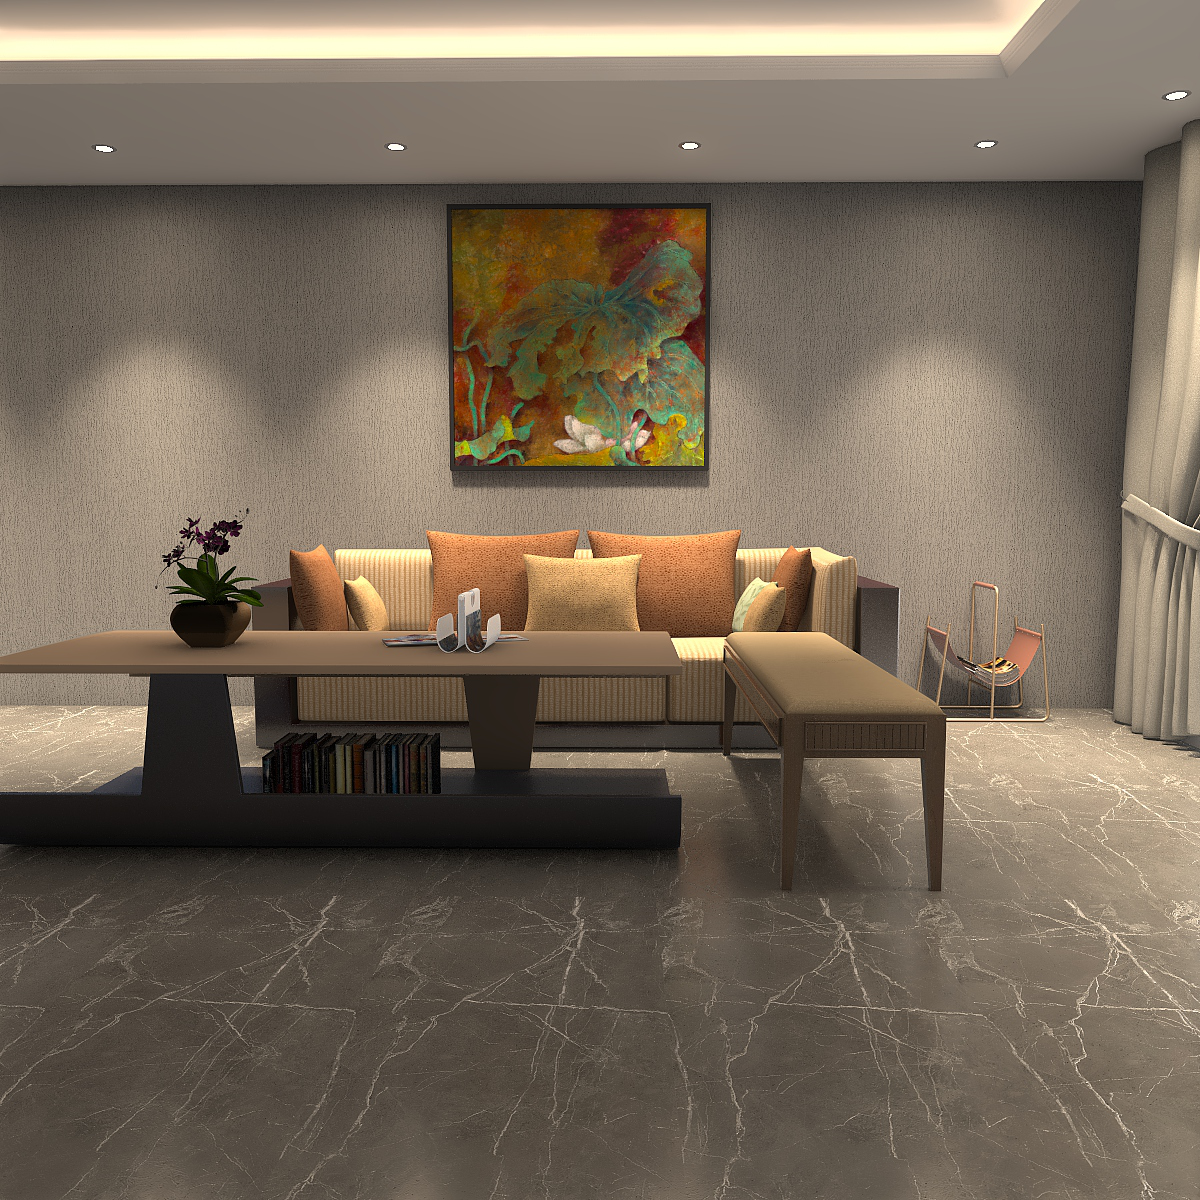

In [16]:
from PIL import Image

# load the input image, convert it from BGR to RGB channel
path_example = os.path.join(os.path.join(DATA_DIR, 'raw_data/train/image'), "0000016.jpg")
Image.open(path_example)

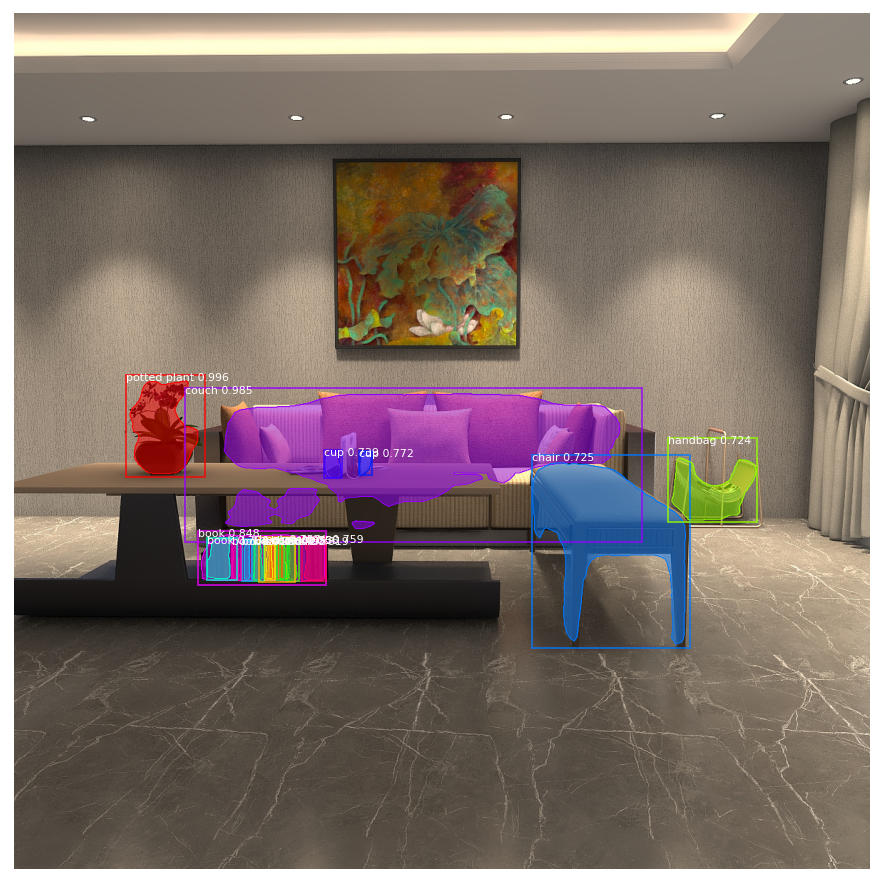

In [17]:
image = cv2.imread(path_example)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])

In [18]:
%cd ..

/content


We observe that the model is not able to detect the frame on the image. We must therefore find a way to label the frames in order to train our new image segmentation model.

In the next sections, we will try to find a way to label our data in order to be able to train a ML model afterwards.

## 2.3 Solution 1: create the dataset manually using matplotlib

This first solution is very simple. The principle is to display an image in an interactive window and to select the corners of the frame manually with the mouse click. The inside of the selected shape will then be filled in with white pixels while the rest of the image will be filled in with black pixels. 

In [19]:
from google.colab import output
output.enable_custom_widget_manager()

In [20]:
import os, itertools
import matplotlib.pyplot as plt

def list_files(path_blob):
    images_dir = os.path.join(DATA_DIR, path_blob)
    list_elem = os.listdir(images_dir) 
    number_files = len(list_elem)
    print(f"Number of files in the {path_blob} folder: {number_files}")
    return list_elem, number_files


# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='gray')
    plt.show()

In [21]:
import matplotlib.pyplot as plt
import IPython.display as Disp
from ipywidgets import widgets
import numpy as np
import cv2

class bbox_select():

    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im)
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)

    def poly_img(self, img, pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),2)
        return img

    def onclick(self, event):
        print("Clicked")
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            pts = np.array(self.selected_points, np.int32)
            pts = pts.reshape((-1,1,2))
            cv2.polylines(self.im.copy(),[pts],True,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),3)


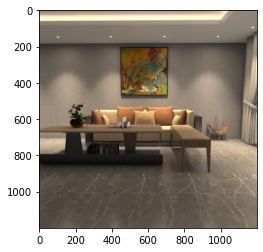

In [22]:
from PIL import Image
import numpy as np
import os

path_image = os.path.join(os.path.join(DATA_DIR, 'raw_data/train/image'), "0000016.jpg")
im = plt.imread(path_image)

try:
  %matplotlib ipympl
  bs = bbox_select(im)
except:
  %matplotlib inline
  bs = bbox_select(im)

In [23]:
nbr_points = len(bs.selected_points)
if nbr_points > 0:
  print(f"You clicked on {nbr_points} points")
  selected_points = bs.selected_points
else:
  selected_points = [[459.32339955849886, 200.6037527593819], [453.80463576158934, 454.4668874172186], [713.1865342163354, 454.4668874172186], [713.1865342163354, 200.6037527593819]]
selected_points

[[459.32339955849886, 200.6037527593819],
 [453.80463576158934, 454.4668874172186],
 [713.1865342163354, 454.4668874172186],
 [713.1865342163354, 200.6037527593819]]

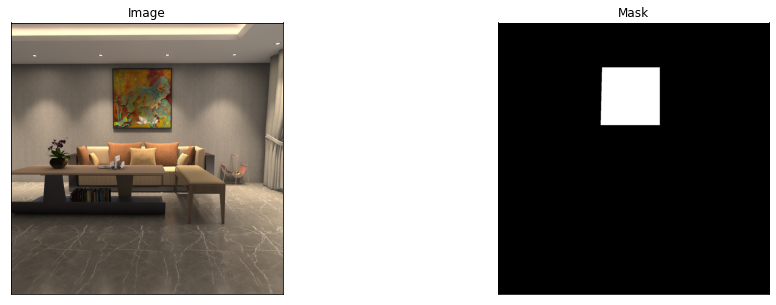

In [24]:
%matplotlib inline
arr = np.array([selected_points],'int')
mask = cv2.fillPoly(np.zeros(im.shape, np.uint8), pts=arr, color=[255, 255, 255])

visualize(
    image=im,
    mask=mask
)

## 2.4 Solution 2: create the  dataset manually using idmap images

In this solution, we will try to find the mask of an object on an image according to the idmap of this image. Indeed, by indicating which colours represent the mask in the idmap, it is very easy to construct the mask.

In [25]:
path_blob_images = 'raw_data/train/image'
path_blob_idmap = 'raw_data/train/idmap'
list_images, _ = list_files(path_blob=path_blob_images)
list_idmap, _ = list_files(path_blob=path_blob_idmap)
count = 0

Number of files in the raw_data/train/image folder: 14761
Number of files in the raw_data/train/idmap folder: 14761


### Visualize images from the original dataset

Let's first have a look at the original image and the corresponding idmap.

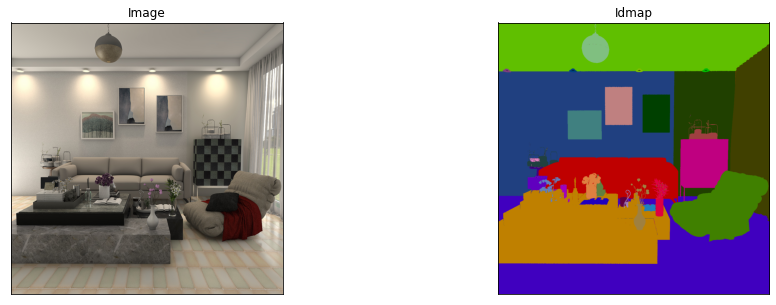

In [26]:
%matplotlib inline
from PIL import Image
import numpy as np
import os

image_dir = os.path.join(DATA_DIR, path_blob_images)
idmap_dir = os.path.join(DATA_DIR, path_blob_idmap)

index = 49
path_image = list_images[index]
path_idmap = list_idmap[index]

img = Image.open(os.path.join(image_dir, path_image))
idmap = Image.open(os.path.join(idmap_dir, path_idmap))

visualize(
    image=img, 
    idmap=idmap
)

### Identify colors from the idmap

In order to identify the frames on the picture, we will identify which color is representing a frame on the picture. In this case, you see 3 different frames represented by 3 different colors: 
- light blue
- light pink
- dark green

In [27]:
from typing import List
import pandas as pd
from colormap import rgb2hex

def from_rgb_to_hex(rgb_colors):
    hex_colors = []
    for (occurences, rgb) in rgb_colors:
      hex_colors.append([rgb2hex(rgb[0], rgb[1], rgb[2]), rgb, occurences])
    return hex_colors


def row_style(row):
    color_to_apply = row.hex
    return pd.Series(f'background-color: {color_to_apply}', row.index)


def display_hex_colors(hex_colors):
    """Visualize a list of hex colors using pandas"""
    df = pd.DataFrame(hex_colors)
    df.columns = ["hex", "rgb", "occurences"]
    df = df[df.occurences > 7000].reset_index()
    hex = list(df["hex"])
    df = df.style.apply(row_style, axis=1)
    display(df)

hex_colors = from_rgb_to_hex(idmap.getcolors())
display_hex_colors(hex_colors)

### Generate mask and save it in the new training set

Now that we found these colors, we can generate the binary mask. In other words, we will create a black picture on which we will highlight some white pixels. These pixels will be the frames.

In [28]:
def modify_pixels(image, pixels):

  width, height = image.size

  # Process every pixel
  for x in range(width):
    for y in range(height):
        current_color = image.getpixel( (x,y) )
        if current_color not in pixels:
          new_color = (0, 0, 0)
        else:
          new_color = (255, 255, 255)
        image.putpixel((x,y), new_color)
  
  return image

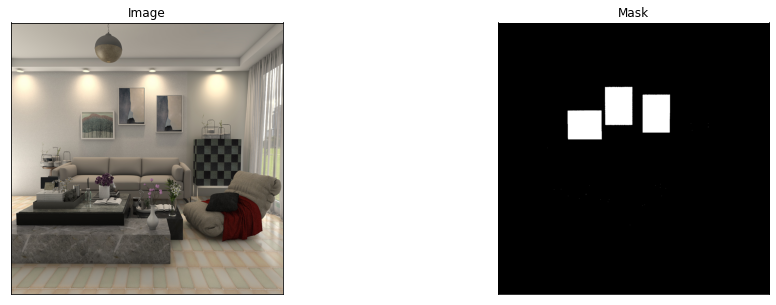

In [29]:
idmap_mask = modify_pixels(idmap, [(0, 64, 0), (64, 128, 128), (191, 128, 128)])
visualize(
    image=img, 
    mask=idmap_mask
)

You can also create a validation and a test set using the same method. 

### Nice but can we find a pattern in colors used in the idmap to detect frames?

Detecting the frame masks by manually finding the idmap colors representing the frames works but it is very time consuming. We can ask ourselves if it is possible to find some clusters of annotators. In other words, the question is: Is it possible to deduce what color the annotators gave the frames? 

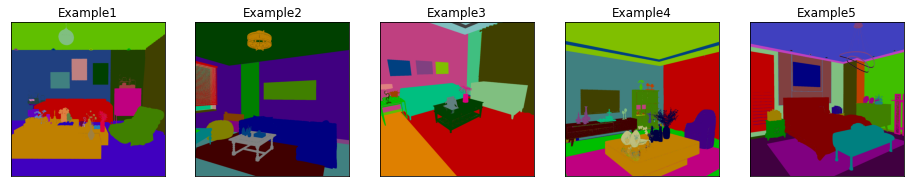

In [41]:
indexes = [49, 4, 36, 29, 17]

idmap_dir = os.path.join(DATA_DIR, path_blob_idmap)
path_idmap = list_idmap[index]
idmap = Image.open(os.path.join(idmap_dir, list_idmap[indexes[0]]))

visualize(
    example1=Image.open(os.path.join(idmap_dir, list_idmap[indexes[0]])), 
    example2=Image.open(os.path.join(idmap_dir, list_idmap[indexes[1]])),
    example3=Image.open(os.path.join(idmap_dir, list_idmap[indexes[2]])),
    example4=Image.open(os.path.join(idmap_dir, list_idmap[indexes[3]])),
    example5=Image.open(os.path.join(idmap_dir, list_idmap[indexes[4]])),
)

After looking at 5 random idmaps, we can easily deduce that the frames always have different colors, so it is not possible to deduce the color given to the frames by the different annotators. This method of frame detection is therefore not at all optimal

## 2.5 Solution 3: create the data set automatically using OpenCV

This last solution is the one that has been used to create the dataset that will be given as input of the image segmentation model. The goal of this solution is to use OpenCV to detect frames automatically. Indeed, frames have some characteristics that can be easily recognized:
- 4 edges 
- Rectangle 
- More than 4000 pixels

[OpenCV](https://opencv.org/about/) is a well-known open-source computer vision library that you can use very easily. 

In [42]:
import os
set_type = "raw_data/train"

images_dir = os.path.join(DATA_DIR, set_type + '/image')
idmap_dir = os.path.join(DATA_DIR, set_type + '/idmap')

list_elem = os.listdir(images_dir) 
number_files = len(list_elem)
print(f"Number of files in the images folder: {number_files}")

list_idmap = os.listdir(idmap_dir) 
number_files = len(list_idmap)
print(f"Number of files in the idmap folder: {number_files}")

Number of files in the images folder: 14761
Number of files in the idmap folder: 14761


In [43]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='gray')
    plt.show()


def find_mask(img):
    count = 0
    new_img = np.zeros(img.shape).astype(img.dtype)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(img,100,200)
    kernal = np.ones((2,2),np.uint8)
    dilation = cv2.dilate(edges, kernal , iterations=2)
    bilateral = cv2.bilateralFilter(dilation,9,75,75)
    contours, hireracy = cv2.findContours(bilateral,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for i,contour in enumerate(contours):
        approx = cv2.approxPolyDP(contour, 0.01*cv2.arcLength(contour,True),True)   
        if len(approx) == 4:

            X,Y,W,H = cv2.boundingRect(approx)
            area = cv2.contourArea(contour)

            # Keep only rectangles of more than 4000 pixels to avoid very small ones
            if area > 4000 :
                count += 1
                box = cv2.rectangle(img, (X,Y), (X+W,Y+H), (0,0,255), 2)
                cropped = img[Y: Y+H, X: X+W]
                cv2.drawContours(new_img, [approx], 0, (255,255,255),1)
                cv2.fillPoly(new_img, pts =[approx], color=(255,255,255))

    return new_img, count

### Let's look at an example

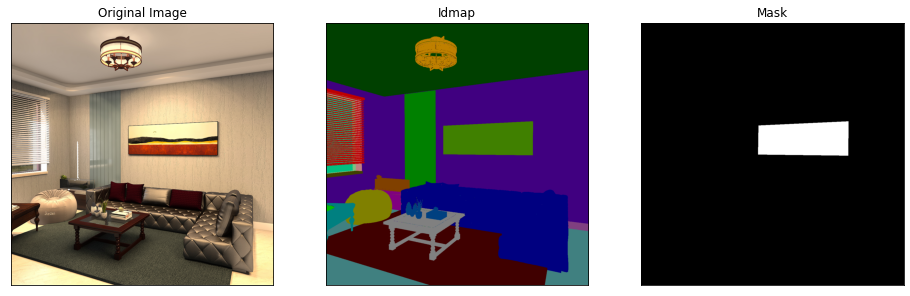

In [44]:
index = 4

path_image = list_elem[index]
path_idmap = list_idmap[index]

original_img = Image.open(os.path.join(images_dir, path_image))
idmap = Image.open(os.path.join(idmap_dir, path_idmap))

img, count = find_mask(np.asarray(idmap))
visualize(
    original_image=original_img,
    idmap=idmap,
    mask=img
)

# 3 Train the new image segmentation model

In this section, we will train a new image segmentation model using the data that was created in the previous section. The goal is to build an image segmentation model capable of detecting frames on a picture and creating a mask of these frames.

In [56]:
!pip install -q segmentation-models
!apt install -q --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists...
Building dependency tree...
Reading state information...
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 20 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 6s (68.3 MB/s)
(Reading database ... 128220 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 128187 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_a

## Load the image segmentation pretrained model

As the training of a new model takes time, there is already a model pretrained in the Cloud that you can easily load and reuse. 

In [57]:
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import tensorflow as tf

def read_img(image, mask):
  '''Read, decode into array, resize and rescale images and masks'''
  im = tf.io.read_file(image)
  im = tf.image.decode_jpeg(im, channels = 3)
  im = tf.image.resize(im, [224, 224])
  im = im/255
  
  msk = tf.io.read_file(mask)
  msk = tf.image.decode_jpeg(msk, channels=3)
  msk = tf.image.resize(msk, [224, 224])
  msk = tf.cast((msk==255),float)
  return im, msk

In [74]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

with tf.device(device_name):
  model = sm.Unet('efficientnetb0', classes=1, activation='sigmoid')
  optim = tf.keras.optimizers.Adam(0.0001)
  dice_loss = sm.losses.DiceLoss()
  focal_loss = sm.losses.BinaryFocalLoss()
  total_loss = dice_loss + (1 * focal_loss)
  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
  model.compile(optim, total_loss, metrics)

In [75]:
x_valid_dir = os.path.join(DATA_DIR, 'validation_frames/images')
y_valid_dir = os.path.join(DATA_DIR, 'validation_frames/masks')

test_df = pd.DataFrame()
test_df['image'] = [os.path.join(x_valid_dir, file) for file in os.listdir(x_valid_dir)]
test_df['mask'] = [os.path.join(y_valid_dir, file).replace('.jpg', '.png') for file in os.listdir(x_valid_dir)]

test_ds = tf.data.Dataset.from_tensor_slices((test_df['image'], test_df['mask']))
test_unbatch = test_ds.map(read_img)
test = test_unbatch.batch(2)

The following cell loads the model that was pretrained and evaluates its performance on the test set.

In [70]:
!wget -O best_model.h5 'https://storage.googleapis.com/home_design_bucket/models/best_model.h5'

--2023-03-04 13:28:00--  https://storage.googleapis.com/home_design_bucket/models/best_model.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.128, 173.194.213.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41070592 (39M) [application/octet-stream]
Saving to: ‘best_model.h5’

best_model.h5       100%[===================>]  39.17M  19.7MB/s    in 2.0s    

2023-03-04 13:28:02 (19.7 MB/s) - ‘best_model.h5’ saved [41070592/41070592]



In [72]:
# Evaluate model performance on "test" set
model.load_weights("best_model.h5")
scores = model.evaluate(test)
print("Loss: {:.5}".format(scores[0]))

526/526 [==============================] - 694s 1s/step - loss: 0.0902 - iou_score: 0.8808 - f1-score: 0.9256
Loss: 0.090169


## Check if the pretrained model performs well on test data

In order to evaluate the performance of the model that we trained in the previous section, we will use an unseen image and try to predict the mask of the frame on this image.

1/1 [==============================] - 6s 6s/step


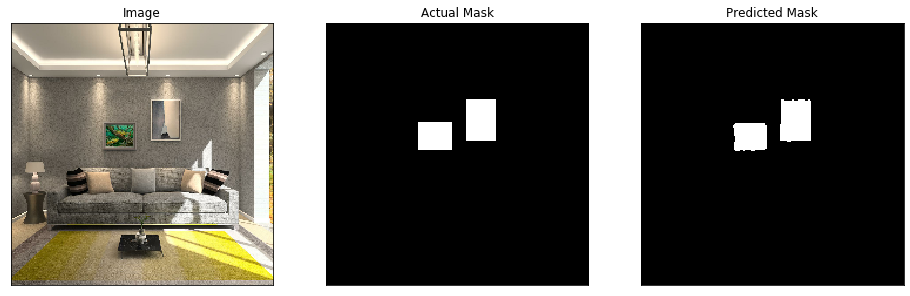

1/1 [==============================] - 0s 29ms/step


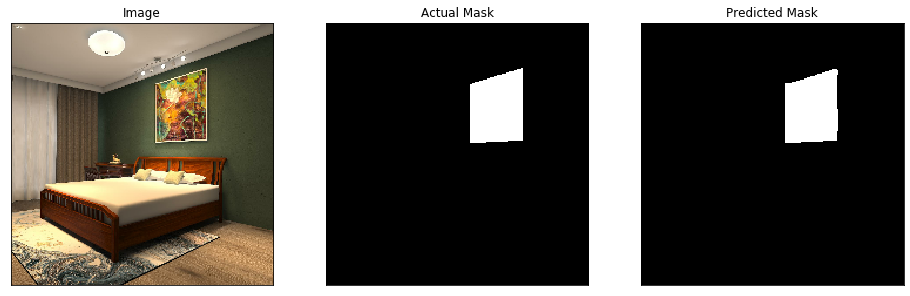

In [ ]:
test_show = list(test_unbatch.take(3).as_numpy_iterator())

for i in range(2):
  eximage, exmask = test_show[i]
  image = eximage
  gt_mask = exmask
  image = np.expand_dims(image, axis=0)
  pr_mask = model.predict(image).round()

  visualize(
      image = image.squeeze(),
      actual_mask=gt_mask.squeeze(),
      predicted_mask=pr_mask.squeeze()
  )

# <span style="color:orange">Style transfer - Exercise </span>

In the previous chapter, you learnt how to create and train an image segmentation model in order to detect frames on a picture. The goal of this second chapter of the exercise session is to learn how to apply a new style to the frame that you detected previously. 

It's time to show your creativity!


# 1 Choose the image to custom

The image to be customized shows a meeting room at the dataroots office. This image was stored in GCP so that you can access it easily. 


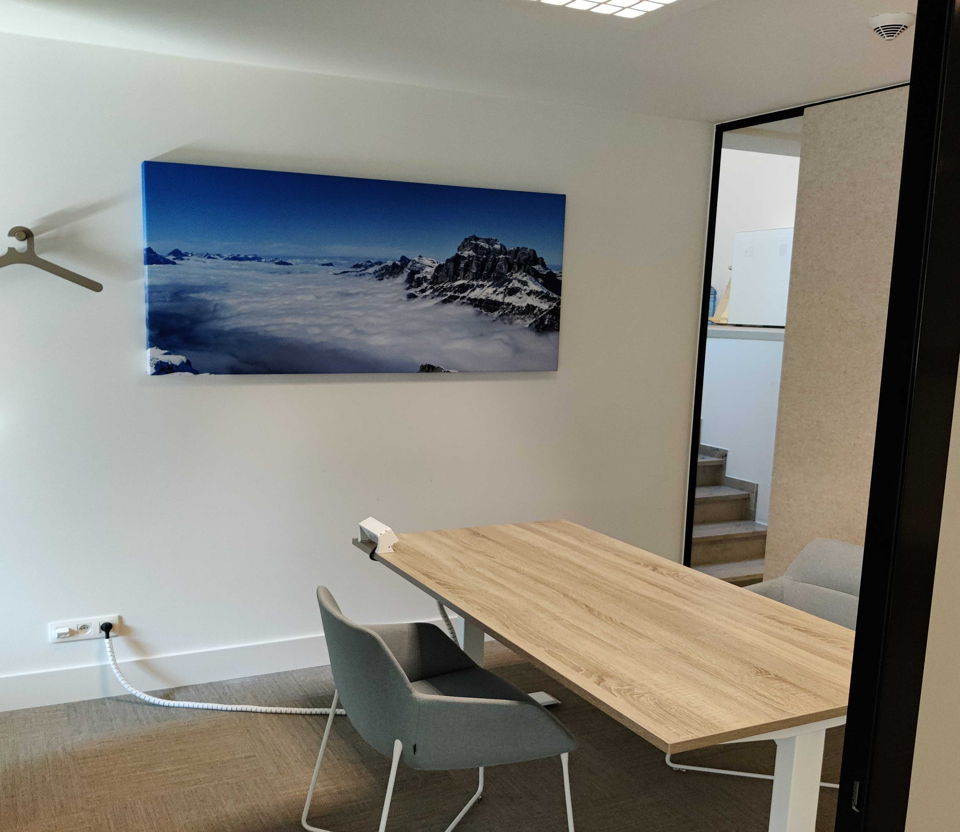

In [ ]:
from PIL import Image
import os
import numpy as np
from IPython.display import display

image_to_custom = os.path.join(DATA_DIR, 'styles/image_to_custom.jpg')

img = Image.open(image_to_custom)
width, height = img.size
idx = np.argmin([width,height])

if idx==0:
  top= (height-width)//2
  bottom= height-(height-width)//2
  left = 0
  right= width
else:
  left = (width-height)//2
  right = width - (width-height)//2
  top = 0
  bottom = height

newsize = (960, 832)
new_img = img.crop((left, top, right, bottom))
new_img = new_img.resize(newsize)

new_img.save(f"image_to_custom.jpg")
display(new_img)

# 2 Choose the pattern to apply to the image

It's now time to choose the pattern that you want to apply to the frame. You can either load a pattern that is already stored in Azure (but there are only 4 possibilites) or you can upload your own pattern locally.

## Load pattern from Cloud


In [ ]:
# Get style example from Azure 
import os
from PIL import Image

styles = {
    "multi-color": "styles/multicolor_pattern.jpeg",
    "tiger": "styles/tiger_pattern.jpeg",
    "water": "styles/water_pattern.jpeg",
    "zebra": "styles/zebra_pattern.jpeg",
    "zebra-color": "styles/zebra_color_pattern.jpeg"
}

pattern = "zebra-color"
style_path = os.path.join(DATA_DIR, styles[pattern])
img = Image.open(style_path)
img.save(f"{pattern}.jpg")

## Upload pattern locally

In [ ]:
from google.colab import files

uploaded = files.upload()

style_path = list(uploaded.keys())[0]

Saving pattern.jpeg to pattern.jpeg


## Resize the pattern image chosen and display it

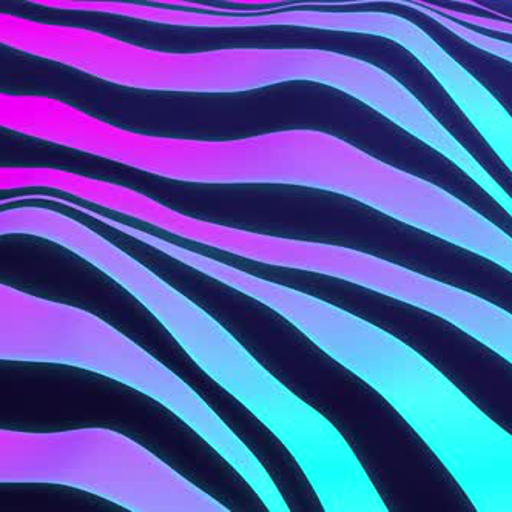

In [ ]:
from PIL import Image
from IPython.display import display
import numpy as np

img = Image.open(style_path)
width, height = img.size
idx = np.argmin([width,height])

if idx==0:
  top= (height-width)//2
  bottom= height-(height-width)//2
  left = 0
  right= width
else:
  left = (width-height)//2
  right = width - (width-height)//2
  top = 0
  bottom = height

newsize = (512, 512)
im1 = img.crop((left, top, right, bottom))
im1 = im1.resize(newsize)
display(im1)

## Customize your pattern

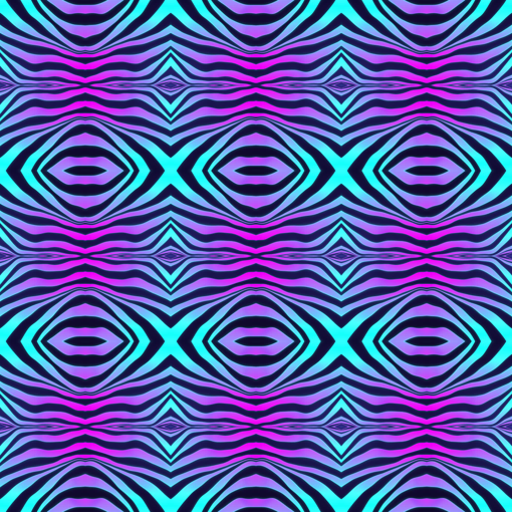

In [ ]:
copies = 6
resize = (newsize[0]//copies,newsize[1]//copies)
dst = Image.new('RGB', (resize[0]*copies,resize[1]*copies))
im2 = im1.resize((resize))
for row in range(copies):
  im2 = im2.transpose(Image.FLIP_LEFT_RIGHT)
  for column in range(copies):
    im2 = im2.transpose(Image.FLIP_TOP_BOTTOM)
    dst.paste(im2, (resize[0]*row, resize[1]*column))
dst = dst.resize((newsize))
dst.save('./style_customized.jpg')
display(dst)

# 3 Apply the pattern on the entire image

The goal of this section is to apply the pattern to the entire picture.

In [ ]:
!git clone https://github.com/diyiiyiii/StyTR-2.git

Cloning into 'StyTR-2'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 83 (delta 10), reused 9 (delta 9), pack-reused 69
Unpacking objects: 100% (83/83), done.


In [ ]:
# Get pre-trained model from the cloud
import os 
vgg_path = os.path.join(DATA_DIR, "models/vgg_normalised.pth")
decoder_path = os.path.join(DATA_DIR, "models/decoder_iter_160000.pth")
transformer_path = os.path.join(DATA_DIR, "models/transformer_iter_160000.pth")
embedding_path = os.path.join(DATA_DIR, "models/embedding_iter_160000.pth")
uploaded_image = "image_to_custom.jpg"

In [ ]:
!mv workshop-image-segmentation-style-transfer/scripts/apply_pattern.py StyTR-2/

In [ ]:
!python StyTR-2/apply_pattern.py  --content $uploaded_image \
                  --style style_customized.jpg  \
                  --output  .\
                  --vgg $vgg_path \
                  --decoder_path $decoder_path \
                  --Trans_path $transformer_path \
                  --embedding_path $embedding_path

image_to_custom.jpg
<class 'int'>
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


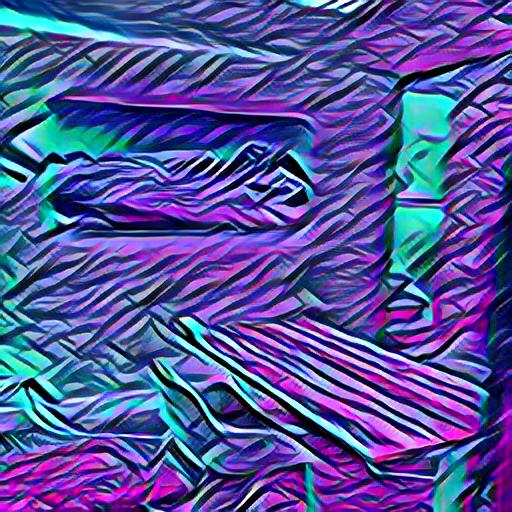

In [ ]:
# Let's look at the styled image
from IPython.display import Image, display
path_styled_image = uploaded_image.split(".")[0] + "_stylized_style_customized.jpg"
display(Image(filename=path_styled_image))

# 4 Get final customized image

This is the final step of this exercise session. The goal is to get the final customized image. To get this, you will need to apply the style only to the frame we want to custom instead of applying it to the full picture.

## Get the mask of the object we want to custom 

In [ ]:
import matplotlib.pyplot as plt

# helper function for data visualization 
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


In the previous chapter, you trained an image segmentation model. If this model gave you satisfying results, you can use it to predict the mask of the frame to customize. Otherwise, don't worry! You can load the actual mask of the frame from GCP. 

### Predict the mask or get it from GCP

The mask of the image to customize can be found thanks to two methods: 
- Using the image segmentation model that you trained in the previous section
- Using the actual mask already stored in the cloud

Get actual mask from the cloud


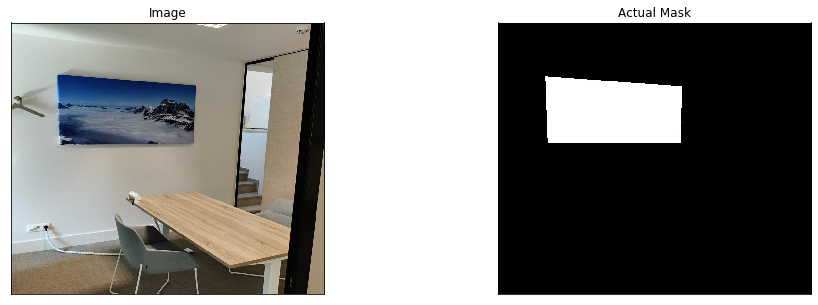

In [ ]:
actual_mask = os.path.join(DATA_DIR, 'styles/actual_mask.jpg')
uploaded_image = "image_to_custom.jpg"
from PIL import Image

if os.path.isfile("./best_model.h5") == True:
  print("Predicting mask")
  actual_mask = os.path.join(DATA_DIR, 'styles/actual_mask.jpg')
  uploaded_image = "image_to_custom.jpg"

  frame_test = pd.DataFrame()
  frame_test['image'] = [uploaded_image]
  frame_test['mask'] = [actual_mask]
  frame_test_ds = tf.data.Dataset.from_tensor_slices((frame_test['image'], frame_test['mask']))

  test_map = frame_test_ds.map(read_img)
  eximage, exmask = list(test_map.shuffle(10).take(1).as_numpy_iterator())[0]
  image = np.expand_dims(image, axis=0)
  pred_mask = model.predict(image).round()

  visualize(
      original_image = image.squeeze(),
      actual_mask=actual_mask.squeeze(),
      predicted_mask=pred_mask.squeeze()
  )

  formatted = (pred_mask.squeeze() * 255 / np.max(pred_mask.squeeze())).astype('uint8')
  pred_mask_to_save = Image.fromarray(formatted)
  pred_mask_to_save.save('mask.jpg')

else:
  print("Get actual mask from the cloud")
  actual_mask = os.path.join(DATA_DIR, 'styles/actual_mask.jpg')
  original_img = Image.open(uploaded_image)

  mask = Image.open(actual_mask)
  visualize(
          image=original_img,
          actual_mask=mask
  )

  mask.save("mask.jpg")

## Apply style only on the chosen object

The last step of this exercise session is to apply the new style only on the wallframe and not on the entire picture using the mask determined in the previous section.

In [ ]:
content_image = "image_to_custom.jpg"
generated_image = "image_to_custom_stylized_style_customized.jpg"
content_mask = "mask.jpg"

In [ ]:
import os
import numpy as np
import imageio
from PIL import Image as Img
from PIL import ImageTk

# util function to load masks
def load_mask(mask_path, shape):
    mask = imageio.imread(mask_path, pilmode="L") # Grayscale mask load
    width, height, _ = shape
    mask = np.array(Img.fromarray(mask).resize((width, height))).astype('float32')

    # Perform binarization of mask
    mask[mask <= 127] = 0
    mask[mask > 128] = 255

    max = np.amax(mask)
    mask /= max

    return mask


# util function to apply mask to generated image
def mask_content(content, generated, mask):
    width, height, channels = generated.shape

    for i in range(width):
        for j in range(height):
            if mask[i, j] == 0.:
                generated[i, j, :] = content[i, j, :]

    return generated

  
# util function to generate the final masked image
def save_final_masked(content_image, generated_image, content_mask):
  image_path = os.path.splitext(generated_image)[0] + "_masked.png"

  generated_image = imageio.imread(generated_image, pilmode="RGB")
  img_width, img_height, channels = generated_image.shape

  content_image = imageio.imread(content_image, pilmode='RGB')
  content_image = np.array(Img.fromarray(content_image).resize((img_width, img_height)))

  mask = load_mask(content_mask, generated_image.shape)

  img = mask_content(content_image, generated_image, mask)
  imageio.imwrite(image_path, img)

  return image_path


In [ ]:
save_image_path = save_final_masked(content_image, generated_image, content_mask)
print("Image saved at path : %s" % save_image_path)

Image saved at path : image_to_custom_stylized_style_customized_masked.png


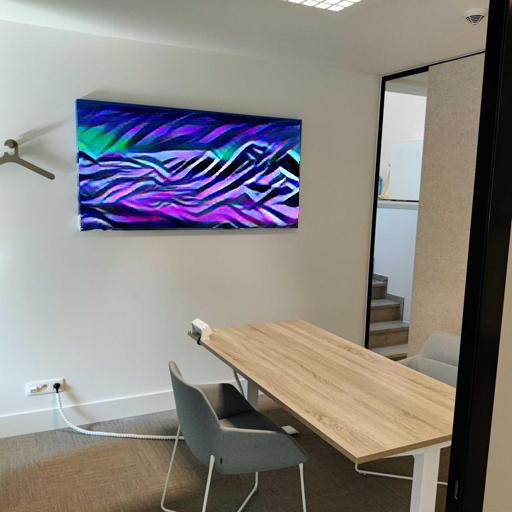

In [ ]:
# Let's look at the final styled image
from IPython.display import Image, display
display(Image(filename="image_to_custom_stylized_style_customized_masked.png"))

**Satisfied with your customization? Upload your final picture on [GCP](https://console.cloud.google.com/storage/browser/home_design_bucket/results?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&project=bootcamp-227610&prefix=&forceOnObjectsSortingFiltering=false) in the "results" folder!**

Note: The name of your file should contain your firstname and lastname. You can also upload the picture you used to build this amazing customization!

# <span style="color:orange">Style transfer with stable diffusion - Exercise </span>

In the previous chapter, you learnt how to create and train an image segmentation model in order to detect frames on a picture. The goal of this second chapter of the exercise session is to learn how to apply a new style to the frame that you detected previously. 

It's time to show your creativity!